Using less data. Spliting train data (Features and tokenized captions)
Using ResNet50 for feature extraction 

Include all the imports 

In [20]:
import pickle
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing import image
import random 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Add
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
import keras_nlp

Open and load the pickle feature file and tokenizer files for train

In [22]:
# Load train image features
with open('./train2014_features.pkl', 'rb') as f:
    image_features = pickle.load(f)

# Load train tokienezd captions
with open('./tokenized_train_captions2.pkl', 'rb') as f:
    tokenized_captions = pickle.load(f)

# Load tokenizer 
with open('./tokenizer2.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Print traininfo
print('Train Photos (with features):', len(image_features))

count = len(tokenizer.word_index) + 1 # add one for the encoding to work at max index
max_len = max(len(i) for j in tokenized_captions.values() for i in j) # max length of words in a caption 
print("Unique word count in vocabulary ",count) # check vocabularu count length 
print("Max length of words in a caption ",max_len) # check max length of words in a caption count 

Train Photos (with features): 82783
Unique word count in vocabulary  24784
Max length of words in a caption  51


Split train features and train tokenized captions into train and test 

In [24]:
print(type(tokenizer))
print(type(image_features))
print(type(tokenized_captions))

first_key = list(image_features.keys())[0]  # get the first image ID
print("Example of first image feature id:", first_key)
print("Example of first image feature value:", image_features.get(first_key))

<class 'keras.src.legacy.preprocessing.text.Tokenizer'>
<class 'dict'>
<class 'dict'>
Example of first image feature id: COCO_train2014_000000000009
Example of first image feature value: [2.2124927  1.928011   3.4857652  ... 0.09374356 3.6251016  0.02294001]


In [26]:
def divide_dataset(features,captions):
    training_features = {} # create a train dictionary 
    training_captions = {}
    validation_features = {} # create a validation dictionary 
    validation_captions = {}

    dataset_keys = list(features.keys())  # All available keys
    dataset_size = len(dataset_keys)

    split_percentage = .80 
    train_sample_count = int(dataset_size * split_percentage)

    random_train_sample_keys = random.sample(dataset_keys, train_sample_count)
    validation_sample_keys = list(set(dataset_keys) - set(random_train_sample_keys))

    # fill training dictionaries
    for key in random_train_sample_keys:
        if key in features and key in captions:
            training_features[key] = features[key]
            training_captions[key] = captions[key]

    # fill validation dictionaries
    for key in validation_sample_keys:
        if key in features and key in captions:
            validation_features[key] = features[key]
            validation_captions[key] = captions[key]

    return training_features, training_captions, validation_features, validation_captions 

Creating data generator 

In [28]:
def create_sequences(tokenizer, max_length, captions, image_feature, vocab_size):
    X1, X2, y = list(), list(), list() 
    
    for seq in captions:  # loop through seq which is a list of integers
        for i in range(1, len(seq)): # loop throguh each integer 
            in_seq, out_seq = seq[:i], seq[i] # create input - output integers

            in_seq = pad_sequences([in_seq], maxlen=max_length)[0] # pad the input 
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0] # encode the output 

            X1.append(image_feature) # add to list
            X2.append(in_seq) # add to list 
            y.append(out_seq) # add to list 
    return np.array(X1), np.array(X2), np.array(y) # return array 

def data_generator(captions, features, tokenizer, max_length, vocab_size, batch_size):
    while True: 
        X1, X2, y = list(), list(), list() 

        for img_id, cap_list in captions.items(): # loop through each img id and caption pair 
            if img_id in features: # if id exists in image feature 
                image_feature = features[img_id] # get the feature vector 
                input_img, input_seq, output_word = create_sequences(tokenizer, max_length, cap_list, image_feature, vocab_size) # check sequences

                for i in range(len(input_img)): #loop through images features in array
                    X1.append(input_img[i]) # get img feature
                    X2.append(input_seq[i]) # get sequence
                    y.append(output_word[i]) # get predicted word 

                    if len(X1) == batch_size:
                        # yeild when needed 
                        yield (
                            (
                                np.array(X1, dtype='float32'),     # features
                                np.array(X2, dtype='int32')         # sequences
                            ),
                            np.array(y, dtype='float32')            # output words
                        )
                        X1, X2, y = list(), list(), list()


Creating CNN+LSTM model

In [29]:
def CNNLSTM_model(count,max_len): # vocbulary total count and max lenght of words for captions 
    # CNN input 
    input1 = Input(shape=(2048,)) # feature vector input shape is 2048 for ResNet50 
    dropout1 = Dropout(0.5)(input1) 
    dense_layer1 = Dense(256,activation='relu')(dropout1) 

    # LSTM
    input2 = Input(shape=(max_len,)) # caption vector input shape is the maxaium length 
    embed = Embedding(count,256,mask_zero=True)(input2)
    dropout2 = Dropout(0.5)(embed)
    dense_layer2 = LSTM(256)(dropout2)

    # Combiniding the models 
    decoder1= Add()([dense_layer1,dense_layer2])
    #decoder1 = tf.keras.layers.Concatenate()([dense_layer1, dense_layer2])
    decoder2 = Dense(256,activation='relu')(decoder1)
    outputs = Dense(count, activation = 'softmax')(decoder2)

    # Image and caption pair input and word output 
    model = Model(inputs=[input1,input2], outputs=outputs)
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer=Adam(learning_rate=0.001))
    model.summary()
    return model 

Training the model 

In [30]:
training_features, training_captions, validation_features, validation_captions = divide_dataset(image_features,tokenized_captions)

In [31]:
# Make sure the model directory exists
os.makedirs("model3_1", exist_ok=True)

batch_size = 32
steps_per_epoch = len(training_features) // batch_size 

# Build the model
model = CNNLSTM_model(count, max_len)
epochs = 10

# Prepare datasets only once
dataset_train = data_generator(training_captions, training_features, tokenizer, max_len, count, batch_size)

#Save the model after each epoch 

checkpoint_callback = ModelCheckpoint(
    "model3_1/model_epoch_{epoch:02d}.h5",  # Path to save the model (using epoch number in filename)
    monitor="loss",  # Monitor the loss for saving (you can also use validation loss, etc.)
    verbose=1,  # Print out information when saving
    save_best_only=False,  # Set to True to save only the best model based on monitored value
    save_weights_only=False,  # Set to True if you want to save only model weights, not the entire model
    mode="min",  # "min" means saving when the loss decreases; can be "max" for accuracy-based models
)

# Train the model once
model.fit(
    dataset_train,  # Training data
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch for training
    epochs=epochs, 
    verbose=1,
    callbacks=[checkpoint_callback] 
)

# Save the model after training
model.save("model3_1/final_model.h5")

print("Training complete.")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 51, 256)   │  6,344,704 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 51, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 51)        │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 24784)     │  6,369,488 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,829,840 (52.76 MB)

 Trainable params: 13,829,840 (52.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 5.5949
Epoch 1: saving model to model3_1/model_epoch_01.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 210s 100ms/step - loss: 5.5946
Epoch 2/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 4.3630
Epoch 2: saving model to model3_1/model_epoch_02.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 223s 108ms/step - loss: 4.3629
Epoch 3/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 4.1028
Epoch 3: saving model to model3_1/model_epoch_03.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 239s 116ms/step - loss: 4.1028
Epoch 4/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 4.0034
Epoch 4: saving model to model3_1/model_epoch_04.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 248s 120ms/step - loss: 4.0034
Epoch 5/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 3.8633
Epoch 5: saving model to model3_1/model_epoch_05.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 234s 113ms/step - loss: 3.8633
Epoch 6/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 3.8221
Epoch 6: saving model to model3_1/model_epoch_06.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 228s 110ms/step - loss: 3.8221
Epoch 7/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 3.7787
Epoch 7: saving model to model3_1/model_epoch_07.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 214s 103ms/step - loss: 3.7787
Epoch 8/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 3.7240
Epoch 8: saving model to model3_1/model_epoch_08.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 218s 106ms/step - loss: 3.7239
Epoch 9/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 3.6946
Epoch 9: saving model to model3_1/model_epoch_09.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 447s 216ms/step - loss: 3.6946
Epoch 10/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 3.6597
Epoch 10: saving model to model3_1/model_epoch_10.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 430s 208ms/step - loss: 3.6597


Training complete.


Test the model 

In [32]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    start = '<start>'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([start])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        pred = model.predict([image, sequence], verbose=0)
        # get index with high probability
        pred = np.argmax(pred)
        # convert index to word
        word = tokenizer.index_word.get(pred)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        start += " " + word
        # stop if we reach end tag
        if word == '<end>':
            break
    
    final_caption = start.split()
    final_caption = final_caption[1:-1]  # remove <start> and <end>
    final_caption = ' '.join(final_caption)
    return final_caption

Model Validation 

In [35]:
# Create metric
bleu_metric = keras_nlp.metrics.Bleu(max_order=4)

# Reset BLEU metric
bleu_metric.reset_state()

for key in tqdm(validation_captions.keys()):
    # Ground truth captions
    captions = validation_captions[key]

    # Decode the ground truth tokenized captions into words
    references = []
    for seq in captions:
        words = [tokenizer.index_word.get(idx, '') for idx in seq if idx > 0]
        references.append(words)

    # Predict the caption
    image_input = validation_features[key].reshape((1, 2048))
    y_pred = predict_caption(model, image_input, tokenizer, max_len)
    y_pred = y_pred.split()

    # BLEU expects list of references and one hypothesis
    bleu_metric.update_state([references], [y_pred])

# Now get BLEU result
bleu_result = bleu_metric.result()

print("BLEU Score (max_order=4):", bleu_result.numpy())

  0%|          | 0/16557 [00:00<?, ?it/s]

  0%|          | 0/16557 [00:04<?, ?it/s]


ValueError: Can't convert non-rectangular Python sequence to Tensor.

Show images and predicted / original captions using the model 


Predicted Image Caption:
a man in a shirt is standing in a field

Oringinal Image Captions Train:
1: a man walking through an unplanted farm land
2: a person walking through a large dirt field
3: a person walking down a long grassy road
4: a person is walking down a field with an animal nearby
5: two people walking in an open field with a sky background


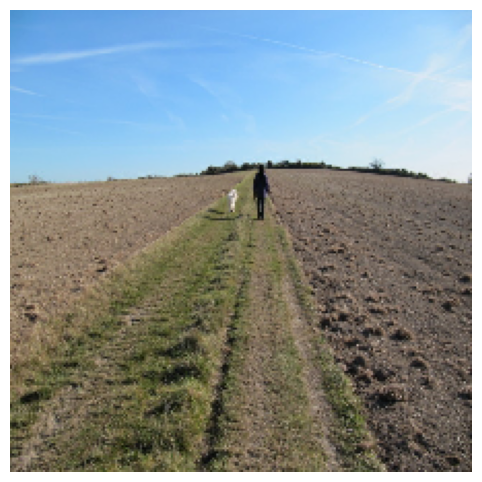


Predicted Image Caption:
a stop sign with a clock on it

Oringinal Image Captions Train:
1: a large indoor building with large glass sky lights
2: a view of the clocks and ceiling of a large station
3: the inside of a large cathedrallike building with an arched ceiling
4: a train station stands majestically and functionally while passengers wait for their train
5: the inside of a large waiting hall is pictured


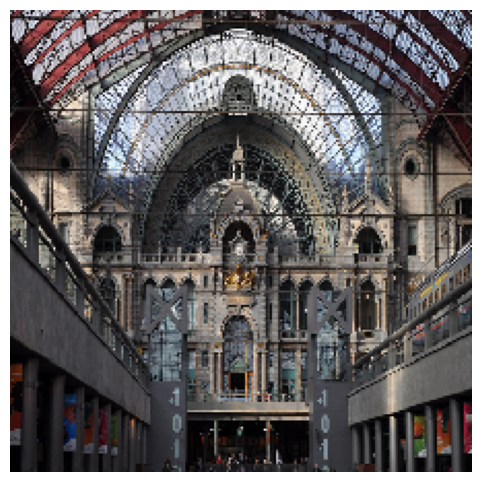


Predicted Image Caption:
a man is standing in a field with a tennis racket

Oringinal Image Captions Train:
1: a man swinging a baseball bat at a baseball field
2: professional baseball player looking up at the ball he just hit
3: a batter looking up after hitting a baseball
4: baseball player watching closely to see where the ball he hit is going
5: baseball scene batter completing swing with fans in background


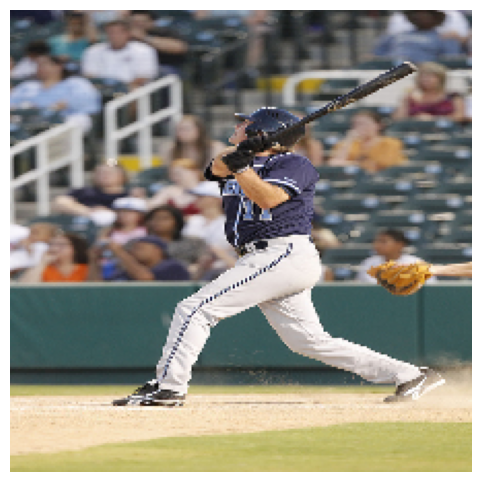


Predicted Image Caption:
a train parked on a street with a train

Oringinal Image Captions Train:
1: a train driving down a set of tracks next to a road
2: a long red train on a snowy day
3: a three car train stopped at a stop
4: a train in front of some trees and a couple of buildings
5: two red train carts and a yellow cart on a track


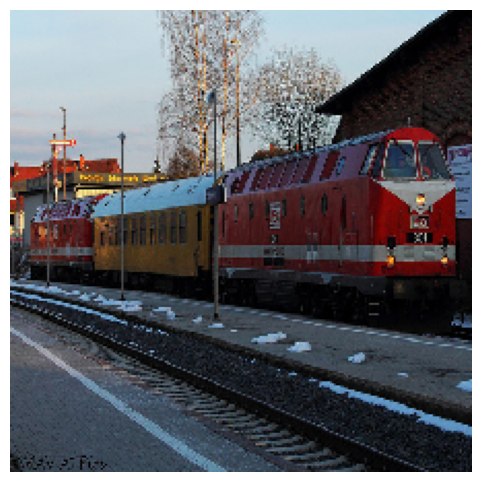


Predicted Image Caption:
a man is standing in front of a table with a frisbee

Oringinal Image Captions Train:
1: a cop standing below the big ben clock tower
2: the man in a yellow vest is standing in front of a clock tower
3: a man in a safety vest stands in front of a clock tower
4: big ben and a police man in a yellow vest and trees
5: a man is standing outside in front of a large building


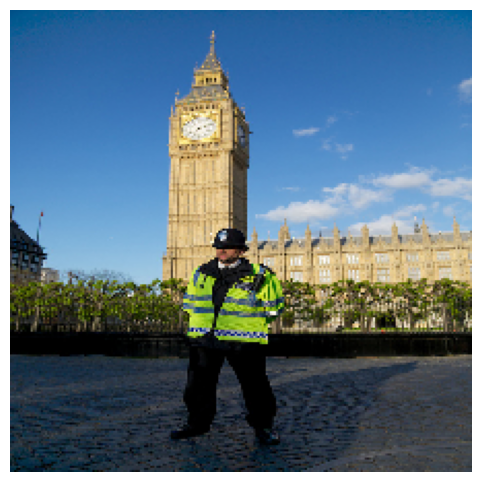

In [55]:
def get_captions2(image_id, image_captions, image_features, image_path, model, tokenizer, max_len):

    # Get the image feature from val_image_features using the filename as the key
    image_feature = image_features.get(image_id, None)
    if image_feature is None:
        print(f"No features found for image ID {image_id}")
        return

    image_feature = image_feature.reshape((1, 2048))
    # Generate a caption using the trained model
    generated_caption = predict_caption(model, image_feature, tokenizer, max_len)

    # Show the image using the load_and_show_image function
    plt.figure(figsize=(8, 6))
    filename = image_id + ".jpg"
    img_path = os.path.join(image_path, filename)

    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')

    print("\nPredicted Image Caption:")
    print(generated_caption)

    # Retrieve and print the real captions
    print("\nOringinal Image Captions Train:")
    real_captions = image_captions.get(image_id, None) 

    if real_captions is None:
        print(f"No original captions found for image ID {image_id}")
    else:
        # Decode tokenized captions into words if they are tokenized
        for idx, caption in enumerate(real_captions):
            # If the caption is a list of token indices, decode it
            if isinstance(caption, list):
                decoded_caption = ' '.join([tokenizer.index_word.get(idx, '') for idx in caption if idx > 0])
                decoded_caption = decoded_caption.split()
                decoded_caption = decoded_caption[1:-1]  # remove <start> and <end>
                decoded_caption = ' '.join(decoded_caption)
                print(f"{idx + 1}: {decoded_caption}")
            else:
                # If it's already a string, simply print it
                print(f"{idx + 1}: {caption}")
            
    # Show the image with captions
    plt.show()

for i in range(5):
    get_captions2(
        image_id=list(validation_features.keys())[i],
        image_captions=validation_captions, 
        image_features=validation_features, 
        image_path="./train2014", 
        model=model,
        tokenizer=tokenizer,
        max_len=max_len
    )
